<a href="https://colab.research.google.com/github/vityasyyy/kmeans-dbscan/blob/main/kmeans_dbscan_nolib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning K-Means and DBScan without Library
## Muhammad Argya Vityasy (23/522547/PA/22475)

## K-Means
### 1. import necessary libraries

In [132]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import random
import math
import urllib.request


### 2. load dataset

In [133]:
# Load the Iris dataset from UCI repository
def load_iris():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8').strip().split('\n')
    X = []
    y = []
    for line in data:
        if line:
            parts = line.strip().split(',')
            features = list(map(float, parts[:4]))
            label = parts[4]
            X.append(features)
            y.append(label)
    return X, y

# Load data
X, y = load_iris()


### 3. Visualize original dataset

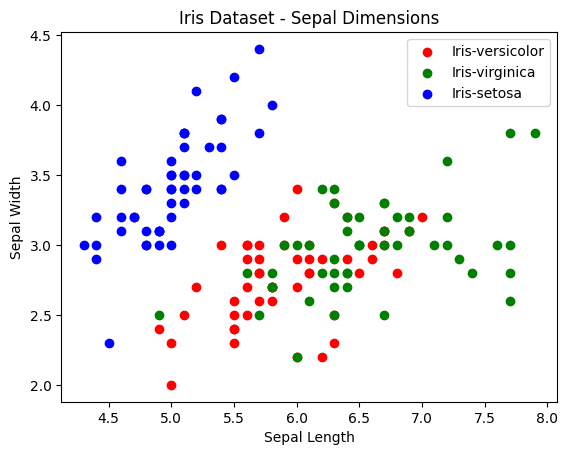

In [134]:
def plot_data(X, y):
    species = list(set(y))
    colors = ['r', 'g', 'b']
    for i, spec in enumerate(species):
        xs = [X[j][0] for j in range(len(X)) if y[j] == spec]
        ys = [X[j][1] for j in range(len(X)) if y[j] == spec]
        plt.scatter(xs, ys, c=colors[i], label=spec)
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    plt.legend()
    plt.title('Iris Dataset - Sepal Dimensions')
    plt.show()

plot_data(X, y)


### 4. K-Means Clustering

In [163]:
def euclidean(a, b):
    """Calculates the Euclidean distance between two points."""
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))

def kmeans(X, k, max_iters=100, tolerance=1e-4, random_seed=None):
    """
    Performs K-Means clustering on a dataset.

    Args:
        X (list of lists): The dataset of points.
        k (int): The number of clusters.
        max_iters (int): Maximum number of iterations to perform.
        tolerance (float): The tolerance for centroid movement to declare convergence.
        random_seed (int or None): Optional seed for random number generation,
                                   ensuring reproducibility if set.

    Returns:
        tuple: A tuple containing the list of labels and the list of centroids.
    """
    # If a random seed is provided, set it for reproducibility.
    # This affects random.sample and random.choice.
    if random_seed is not None:
        random.seed(random_seed)

    # Initialize centroids by randomly sampling k points from the dataset X.
    centroids = random.sample(X, k)

    # Initialize a list to store the cluster label for each data point.
    labels = [0] * len(X)

    # Main K-Means iteration loop
    for _ in range(max_iters):
        # Initialize empty lists to store the *indices* of points belonging to each cluster.
        clusters = [[] for _ in range(k)]

        # --- Assignment step ---
        # Assign each data point to the nearest centroid.
        for idx, x_point in enumerate(X): # Iterate through each point with its index
            # Calculate distances from the current point (x_point) to all current centroids.
            distances = [euclidean(x_point, c) for c in centroids]
            # Find the index of the closest centroid.
            cluster_idx = distances.index(min(distances))

            # Add the *index* of the current point (idx) to the list for the assigned cluster.
            clusters[cluster_idx].append(idx)
            # Assign the cluster index (label) to the current point.
            labels[idx] = cluster_idx

        # Store a deep copy of the current centroids to check for convergence later.
        old_centroids = [c[:] for c in centroids] # Use slicing for a deep copy of each centroid list

        # --- Update step ---
        # Recalculate each centroid as the mean of all points assigned to its cluster.
        for j in range(k): # Iterate through each cluster index j
            if clusters[j]: # If the cluster (identified by index j) is not empty
                # Get all the actual data points belonging to this cluster using their stored indices.
                cluster_points = [X[point_index] for point_index in clusters[j]]
                # Calculate the new centroid as the mean of these points.
                # zip(*cluster_points) transposes the points for easy dimension-wise mean calculation.
                centroids[j] = [sum(dim) / len(dim) for dim in zip(*cluster_points)]
            else:
                # If a cluster is empty, re-initialize its centroid by picking a random point from X.
                # This helps prevent the algorithm from collapsing to fewer than k clusters.
                centroids[j] = random.choice(X)

        # --- Convergence check ---
        # Check if the change in all centroids is within the specified tolerance.
        # The `all()` function returns True if the condition is met for every centroid.
        if all(euclidean(old_centroids[j], centroids[j]) <= tolerance for j in range(k)):
            break # If converged, exit the main loop

    # Return the final labels and centroids.
    return labels, centroids

### 5. Elbow method

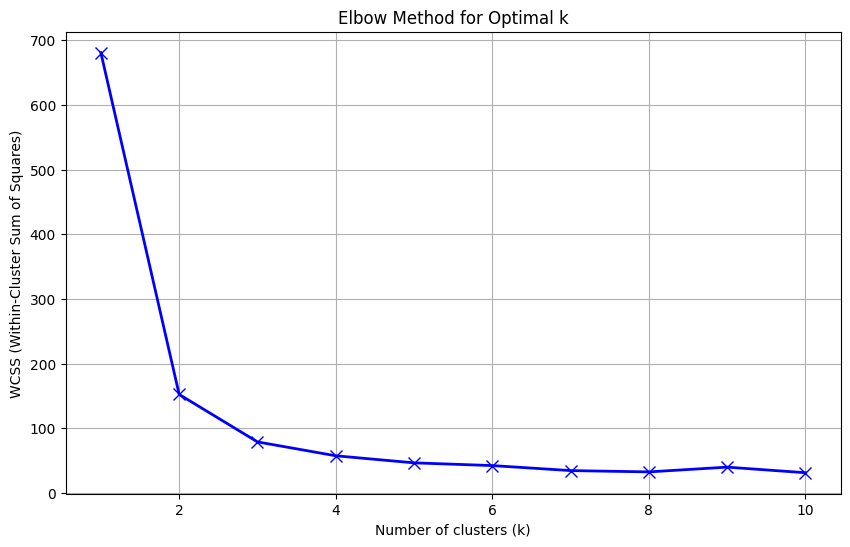

In [164]:

# Function to compute Within-Cluster Sum of Squares (WCSS)
def compute_wcss(X, labels, centroids):
    """
    Calculates the Within-Cluster Sum of Squares.
    WCSS is a measure of how internally coherent the clusters are.
    Lower WCSS means points are closer to the centroids of their assigned clusters.

    Args:
        X (list of lists): The dataset of points.
        labels (list): A list where labels[i] is the cluster ID for X[i].
        centroids (list of lists): A list of centroid coordinates for each cluster.

    Returns:
        float: The total WCSS value.
    """
    wcss = 0  # Initialize WCSS to zero
    # Iterate through each data point and its assigned label
    for i, x_point in enumerate(X):
        # Get the centroid of the cluster to which the current point x_point belongs.
        # labels[i] gives the cluster index (e.g., 0, 1, 2, ...) for point X[i].
        # centroids[labels[i]] then gives the coordinates of that cluster's centroid.
        assigned_centroid = centroids[labels[i]]

        # Calculate the squared Euclidean distance between the point and its assigned centroid.
        # The euclidean() function returns the distance, so we square it (distance ** 2).
        squared_distance = euclidean(x_point, assigned_centroid) ** 2

        # Add this squared distance to the total WCSS.
        wcss += squared_distance

    return wcss # Return the final WCSS value

# ELBOW METHOD
# Initialize an empty list to store WCSS values for different k
wcss_values = []

# Define the range of k values to test.
K_range = range(1, 11) # Test k=1, 2, ..., 10

# Loop through each value of k in K_range
for k_value in K_range:
    # Perform K-Means clustering for the current k_value.
    # This will return the cluster labels for each point and the coordinates of the final centroids.
    # Note: K-Means can yield slightly different results on different runs due to random initialization.
    labels, centroids = kmeans(X, k_value, 29)

    # Compute the WCSS for the clustering result obtained with k_value.
    wcss = compute_wcss(X, labels, centroids)

    # Append the calculated WCSS to list.
    wcss_values.append(wcss)

# PLOT
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss_values, 'bx-', linewidth=2, markersize=8)

plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')

plt.grid(True)
plt.show()


### 7.Visualize K-Means with optimal k, k = 3, based on the elbow

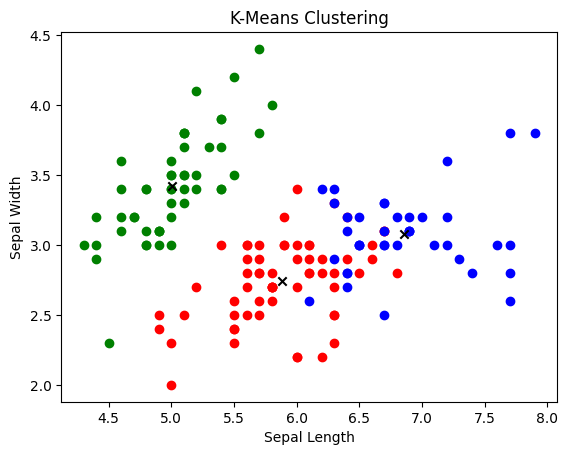

In [166]:
# Visualize clusters
def plot_clusters(X, labels, centroids):
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    for idx, point in enumerate(X):
        plt.scatter(point[0], point[1], c=colors[labels[idx] % len(colors)])
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], c='k', marker='x')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    plt.title('K-Means Clustering')
    plt.show()

# Apply K-Means with k=3
labels, centroids = kmeans(X, 3, 29)
plot_clusters(X, labels, centroids)


## DBSCAN

### 1. Implement DBScan Clustering

In [167]:
def dbscan(X, eps, min_pts):
    """
    Performs DBSCAN clustering on a dataset.

    Args:
        X (list of lists): The dataset of points.
        eps (float): The radius within which to search for neighbors.
        min_pts (int): The minimum number of points to form a dense region (a core point).

    Returns:
        list: A list of cluster labels for each point. Noise points are labeled -1.
    """
    NOISE = -1
    UNVISITED = 0  # Using 0 for unvisited, so cluster IDs will start at 1.

    labels = [UNVISITED] * len(X)
    cluster_id = 0

    def region_query(point_idx):
        """Finds all points within eps distance of a given point."""
        neighbors = []
        for i in range(len(X)):
            if euclidean(X[point_idx], X[i]) <= eps:
                neighbors.append(i)
        return neighbors

    def expand_cluster(point_idx, neighbors, cluster_id):
        """Expands a cluster from a core point."""
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            # Get the next point from the queue of neighbors
            neighbor_idx = neighbors[i]

            # If the neighbor is unvisited
            if labels[neighbor_idx] == UNVISITED:
                labels[neighbor_idx] = cluster_id
                # Find its neighbors to see if it's a core point
                new_neighbors = region_query(neighbor_idx)
                if len(new_neighbors) >= min_pts:
                    # If it is a core point, add its neighbors to the queue
                    neighbors.extend(new_neighbors)

            # If the neighbor was marked as noise, it's a border point. Add it to the cluster.
            elif labels[neighbor_idx] == NOISE:
                labels[neighbor_idx] = cluster_id

            i += 1

    # Main loop to iterate through all points
    for i in range(len(X)):
        # Skip points that have already been visited
        if labels[i] != UNVISITED:
            continue

        # Find neighbors of the current point
        neighbors = region_query(i)

        # If the point doesn't have enough neighbors, mark it as noise (for now)
        if len(neighbors) < min_pts:
            labels[i] = NOISE
        else:
            # It's a core point, so start a new cluster
            cluster_id += 1
            expand_cluster(i, neighbors, cluster_id)

    return labels

### 2. Parameter tuning

In [168]:

# `eps` (epsilon) controls the radius of the neighborhood.
# A smaller `eps` creates tighter, more dense clusters. A larger `eps` allows clusters to be more spread out.
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]

# `min_pts` controls the minimum density of a cluster.
# A higher `min_pts` value requires clusters to be denser and is more robust against noise.
min_pts_values = [2, 3, 4, 5, 6, 7, 8, 9]


for eps in eps_values:
    for min_pts in min_pts_values:
        # The output `labels` is a list where each element tells you which cluster a point belongs to.
        labels = dbscan(X, eps, min_pts)

        # Calculate the number of actual clusters found.
        # `set(labels)` gets the unique cluster IDs (e.g., {-1, 0, 1, 2}).
        # subtract 1 if the noise label (-1) is present, because noise isn't considered a cluster.
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Calculate the number of points that were classified as noise (outliers).
        n_noise = labels.count(-1)

        # Print a summary for this specific (eps, min_pts) combination.
        print(f'eps: {eps}, min_pts: {min_pts}, clusters: {n_clusters}, noise points: {n_noise}')

eps: 0.3, min_pts: 2, clusters: 21, noise points: 43
eps: 0.3, min_pts: 3, clusters: 9, noise points: 67
eps: 0.3, min_pts: 4, clusters: 6, noise points: 81
eps: 0.3, min_pts: 5, clusters: 3, noise points: 96
eps: 0.3, min_pts: 6, clusters: 2, noise points: 106
eps: 0.3, min_pts: 7, clusters: 2, noise points: 108
eps: 0.3, min_pts: 8, clusters: 1, noise points: 118
eps: 0.3, min_pts: 9, clusters: 1, noise points: 118
eps: 0.4, min_pts: 2, clusters: 7, noise points: 16
eps: 0.4, min_pts: 3, clusters: 4, noise points: 22
eps: 0.4, min_pts: 4, clusters: 4, noise points: 25
eps: 0.4, min_pts: 5, clusters: 4, noise points: 32
eps: 0.4, min_pts: 6, clusters: 4, noise points: 32
eps: 0.4, min_pts: 7, clusters: 6, noise points: 47
eps: 0.4, min_pts: 8, clusters: 4, noise points: 66
eps: 0.4, min_pts: 9, clusters: 3, noise points: 78
eps: 0.5, min_pts: 2, clusters: 6, noise points: 6
eps: 0.5, min_pts: 3, clusters: 4, noise points: 10
eps: 0.5, min_pts: 4, clusters: 3, noise points: 13
eps: 0.5

### 3. DBSCAN Result with tuned params

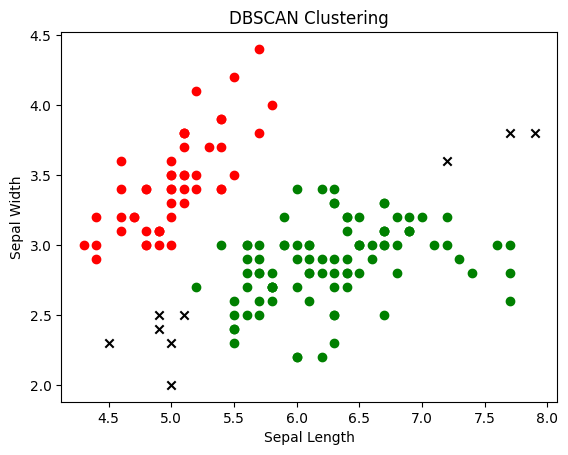

In [169]:
# Visualize DBSCAN clusters
def plot_dbscan(X, labels):
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    for idx, point in enumerate(X):
        label = labels[idx]
        if label == -1:
            plt.scatter(point[0], point[1], c='k', marker='x')  # Noise
        else:
            plt.scatter(point[0], point[1], c=colors[(label - 1) % len(colors)])
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    plt.title('DBSCAN Clustering')
    plt.show()

# play with the parameter given by the param tuning
dbscan_labels = dbscan(X, eps=0.6, min_pts=5)
plot_dbscan(X, dbscan_labels)
